In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# upload just a sample dataframe for example purpose
data1 = pd.read_csv('dataframe_cleaned.csv')

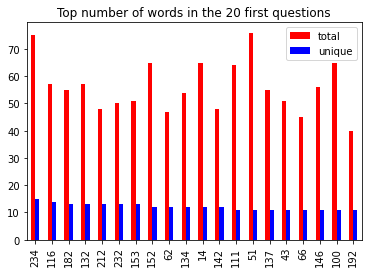

In [2]:
import nltk
import re
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
# could be also used
#from nltk.stem import PorterStemmer
#from nltk.stem import LancasterStemmer
from nltk.stem.snowball import SnowballStemmer

tokenizer = nltk.RegexpTokenizer(r'\w+')
wordnet_lemmatizer = WordNetLemmatizer()
frenchStemmer=SnowballStemmer('french')

List_desp = data1['Question'].tolist()

stats, freq = dict(), dict()
il= 0
for list_k in List_desp:
    
    freq[il] = fq = nltk.FreqDist(tokenizer.tokenize(list_k.lower())) 
    stats[il] = {'total': len(list_k), 'unique': len(fq.keys())}
    il +=1
df_stats = pd.DataFrame.from_dict(stats, orient='index')
df_stats.sort_values(by='unique', ascending=False)[:20].plot(kind='bar', color=['red','blue'], title='Top number of words in the 20 first questions')
plt.show()

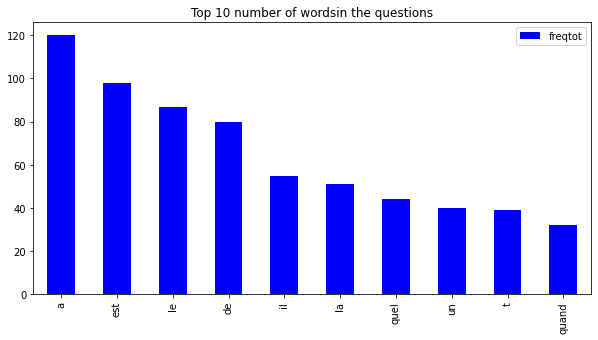

In [4]:
freq_totale = nltk.Counter()
il2= 0
for list_k2 in List_desp:
    freq_totale += freq[il2]
    il2 +=1
df_freqtot = pd.DataFrame.from_dict(freq_totale, orient='index')
df_freqtot.columns = ['freqtot']
df_freqtot.sort_values(by='freqtot', ascending=False)[:10].plot(kind='bar', 
                                                                color=['blue'],
                                                                figsize=(10,5),
                                                                title='Top 10 number of wordsin the questions')
plt.show()

In [5]:
from nltk import word_tokenize, pos_tag

#setting limit of frequent words, here 5% top most common words
mc_limit = int(np.ceil(0.05*df_freqtot.shape[0]))
print('The limit of 5% of most common words represents: {} words'.format(mc_limit))
# setting stopwords
sw1 = set()
sw1.update(tuple(list(zip(*freq_totale.most_common(mc_limit)))[0]))
sw1.update(tuple(nltk.corpus.stopwords.words('french')))
len(sw1)


corpora_tok_original, corpora_tok_lem, corpora_tok_stem = dict(), dict(), dict()
L_str_original, L_str_lem, L_str_stem = [], [], []
#    list_k = list_red[0]
# corpora[0] = [stemmer.stem(w) for w in tok_list_temp if not w in list(sw1)]

il3= 0
for list_k in List_desp:
    # removing digits
    list_kre= re.sub(r'\d+',' ',list_k)
    # removing words with less than 3 characters
    list_kre2 = re.sub(r'\b\w{1,2}\b', '', list_kre)
    tok_list_temp = tokenizer.tokenize(list_kre2.lower())
    # Remaining tokens stored as a list for each product
    # Removing stop words and keeping only nouns and adjectives
    corpora_tok_original[il3] = [w for (w, p) in pos_tag(tok_list_temp) if ((w not in list(sw1)))]  
    corpora_tok_lem[il3] = [wordnet_lemmatizer.lemmatize(w, pos="v") for (w, p) in pos_tag(tok_list_temp) if (w not in list(sw1))]
    corpora_tok_stem[il3] = [frenchStemmer.stem(w) for (w, p) in pos_tag(tok_list_temp) if ((w not in list(sw1)))]
    
    # tokens merged as a string in a list for each product
    L_str_original.append(' '.join(corpora_tok_original[il3]))
    L_str_lem.append(' '.join(corpora_tok_lem[il3]))
    L_str_stem.append(' '.join(corpora_tok_stem[il3]))
    il3 +=1

# example on the description on the first article
cop_orig0 = pd.DataFrame.from_dict(corpora_tok_original, orient='index').iloc[0]
cop_lem0 = pd.DataFrame.from_dict(corpora_tok_lem, orient='index').iloc[0]
cop_stem0 = pd.DataFrame.from_dict(corpora_tok_stem, orient='index').iloc[0]

# example on the description on the first article
df0_wls = pd.DataFrame({'words':cop_orig0, 'lemma':cop_lem0, 'stem':cop_stem0})
df0_wls.head(3)

The limit of 5% of most common words represents: 26 words


,words,lemma,stem
0,cinéma,cinéma,cinem
1,cette,cette,cet
2,semaine,semaine,semain


In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer 
# settings that you use for count vectorizer also used here
tfidf_vectorizer=TfidfVectorizer(use_idf=True)
 
# just send in all your docs here
tfidf_vectorizer.fit(L_str_lem)
print('Vocabulary size of our corpus: {}'.format(len(tfidf_vectorizer.vocabulary_)))
bow_tfidf=tfidf_vectorizer.transform(L_str_lem)
#print(bow_tfidf)
df_bow_tfidf = pd.DataFrame(bow_tfidf.toarray())
df_bow_tfidf.columns =tfidf_vectorizer.get_feature_names()
df_bow_tfidf.head(3)

Vocabulary size of our corpus: 385


,acheter,acouché,adresse,age,aimerais,alba,aller,amanda,amie,angelina,...,vient,vieux,visiter,voiture,voix,voudrais,yves,édifiée,élections,élu
0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.549648,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
from gensim import matutils, models
import scipy.sparse

#tranpose the bag of words for generating the corpus later
tdm_tfidf = df_bow_tfidf.transpose()
#tdm_tfidf.head()

#from df to sparse matrix to gensim corpus
sparse_counts_tfidf = scipy.sparse.csr_matrix(tdm_tfidf)
corpus_tfidf = matutils.Sparse2Corpus(sparse_counts_tfidf)

# gensim requirement a dictionary word location, word. Basically the tfidf_vectorizer.vocabulary_ where keys and values are interverted
id2word_tfidf = dict((v, k) for k, v in tfidf_vectorizer.vocabulary_.items())

tdm_tfidf.head()

,0,1,2,3,4,5,6,7,8,9,...,240,241,242,243,244,245,246,247,248,249
acheter,0.0,0.549648,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
acouché,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
adresse,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
age,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.675072,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
aimerais,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
# lantent dirichlet allocation based on term frequency inverse document frequency, 3 groups
lda_tfidf_short = models.LdaModel(corpus=corpus_tfidf, id2word=id2word_tfidf, num_topics=3, passes=80)
lda_tfidf_short.print_topics()

[(0,
  '0.028*"appartient" + 0.021*"peux" + 0.015*"trouver" + 0.014*"connais" + 0.012*"numero" + 0.011*"ici" + 0.010*"restaurant" + 0.009*"marie" + 0.009*"telephone" + 0.008*"chirac"'),
 (1,
  '0.022*"environ" + 0.019*"obama" + 0.019*"depuis" + 0.017*"tour" + 0.016*"homme" + 0.012*"montparnasse" + 0.012*"eiffel" + 0.012*"proche" + 0.011*"sarkozy" + 0.011*"paris"'),
 (2,
  '0.030*"hollande" + 0.024*"age" + 0.022*"francois" + 0.022*"appeler" + 0.018*"france" + 0.018*"combien" + 0.011*"femmes" + 0.010*"mort" + 0.010*"appelle" + 0.009*"president"')]

In [8]:
# lantent dirichlet allocation based on term frequency inverse document frequency, 5 groups
lda_tfidf = models.LdaModel(corpus=corpus_tfidf, id2word=id2word_tfidf, num_topics=5, passes=80)
lda_tfidf.print_topics()

[(0,
  '0.023*"proche" + 0.020*"plus" + 0.016*"appelé" + 0.015*"environ" + 0.014*"coin" + 0.012*"femmes" + 0.012*"tiens" + 0.012*"expo" + 0.010*"trouve" + 0.010*"faire"'),
 (1,
  '0.026*"tour" + 0.020*"eiffel" + 0.019*"depuis" + 0.015*"combien" + 0.013*"connais" + 0.012*"sexe" + 0.012*"sarkozy" + 0.012*"reçu" + 0.011*"beyonce" + 0.011*"fête"'),
 (2,
  '0.032*"appeler" + 0.026*"peux" + 0.022*"environ" + 0.021*"trouver" + 0.016*"restaurant" + 0.016*"paris" + 0.012*"métro" + 0.011*"bar" + 0.010*"magasin" + 0.009*"bon"'),
 (3,
  '0.044*"hollande" + 0.041*"appartient" + 0.032*"francois" + 0.031*"age" + 0.024*"obama" + 0.016*"numero" + 0.014*"mort" + 0.014*"ici" + 0.013*"marie" + 0.012*"mandela"'),
 (4,
  '0.026*"homme" + 0.018*"jackson" + 0.018*"michael" + 0.014*"combien" + 0.014*"montparnasse" + 0.013*"président" + 0.011*"france" + 0.011*"élu" + 0.009*"jacques" + 0.009*"chirac"')]

In [10]:
# get the probability to belong to one topic
corpus_transformed = lda_tfidf_short[corpus_tfidf]
get_document_topics = lda_tfidf_short.get_document_topics(corpus_tfidf)
print(np.array(get_document_topics[1]))

[[0.         0.75330913]
 [1.         0.12325051]
 [2.         0.1234404 ]]


In [11]:
# compute the top topic and its related probability for each document
df_gdt = pd.DataFrame(np.zeros((1, 2)), columns=['topic','proba'])
for gdt in get_document_topics:
    df_gdt_temp = pd.DataFrame(np.array(gdt), columns=['topic','proba']).sort_values(by=['proba'], ascending=False).iloc[[0]]
    df_gdt = df_gdt.append(df_gdt_temp)
df_gdt = df_gdt[1:].reset_index().drop(columns='index')
df_gdt.head(3)

,topic,proba
0,1.0,0.740002
1,0.0,0.753309
2,1.0,0.720570


In [12]:
data1['topic'] = df_gdt['topic']
data1['proba'] = df_gdt['proba']

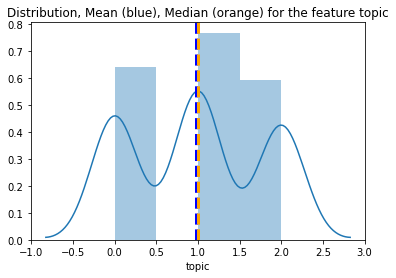

In [13]:
# Function plotting histograms, distribution plots, mean and median for features containing numerical values
def Hist_comp_non_obj_df(data_frame):
    data_frame_Nobj = data_frame.select_dtypes(exclude='object').dropna()
    Nb_col_data_frame_Nobj = data_frame_Nobj.shape[1]
    ih = 1
    for col_data_frame_Nobj in data_frame_Nobj:
        arr_temp = data_frame_Nobj[col_data_frame_Nobj]
        plt.figure(figsize=(6, 4))
        ax_temp = sns.distplot(arr_temp)
        plt.axvline(np.mean(arr_temp), color='b', linestyle='dashed', linewidth=3)
        plt.axvline(np.median(arr_temp), color='orange', linestyle='dashed', linewidth=3)
        plt.title('Distribution, Mean (blue), Median (orange) for the feature {}'.format(col_data_frame_Nobj))
        plt.show()
    return

Hist_comp_non_obj_df(data1[['topic']])

Topics are distributed quite evenly over the documents

In [14]:
# creating list of list of tokens for each cleaned text
df_t_cleaned = pd.DataFrame({'text_cleaned':L_str_lem})
text_cl = df_t_cleaned['text_cleaned']
text_list = [i.split() for i in text_cl]

# Based on the list of list of tokens, creation of Dictionnary and Document Term Matrix for the pyLDA
from gensim import corpora

dictionary_gen = corpora.Dictionary(text_list)
# Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
doc_term_matrix = [dictionary_gen.doc2bow(doc) for doc in text_list] # corpus
print(doc_term_matrix[100])

[(88, 1), (99, 1), (204, 1), (205, 1)]


In [15]:
# checking the coherence for two LDA based on tfidf
from gensim.models import CoherenceModel
# Compute Coherence Score
coherence_model_lda_short = CoherenceModel(model=lda_tfidf_short, texts=text_list, dictionary=dictionary_gen, coherence='c_v')
coherence_lda_short = coherence_model_lda_short.get_coherence()
print('\nCoherence Score LDA 3 topics: ', coherence_lda_short)

coherence_model_lda = CoherenceModel(model=lda_tfidf, texts=text_list, dictionary=dictionary_gen, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score LDA 5 topics: ', coherence_lda)


Coherence Score LDA 3 topics:  0.8376313461668299

Coherence Score LDA 5 topics:  0.8349895384016619


In [17]:
# Topic analysis
import pyLDAvis.gensim
import gensim
pyLDAvis.enable_notebook()


data_pyLDA = pyLDAvis.gensim.prepare(lda_tfidf_short, doc_term_matrix, dictionary_gen)
data_pyLDA

C:\Users\USER\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.000315 -0.087454       1        1  37.165630
1     -0.088795  0.043960       2        1  33.815228
2      0.089110  0.043494       3        1  29.019135, topic_info=    Category      Freq        Term     Total  loglift  logprob
180  Default  7.000000  republique  7.000000  30.0000  30.0000
17   Default  8.000000    hollande  8.000000  29.0000  29.0000
3    Default  5.000000     acheter  5.000000  28.0000  28.0000
156  Default  5.000000      michel  5.000000  27.0000  27.0000
19   Default  5.000000       maine  5.000000  26.0000  26.0000
..       ...       ...         ...       ...      ...      ...
212   Topic3  1.490600    commence  3.113169   0.5008  -4.9662
307   Topic3  1.570821        gare  3.425238   0.4576  -4.9138
165   Topic3  1.221427      depuis  2.394351   0.5641  -5.1654
328   Topic3  1.146747        amie  2.184604   0.5927  -5.2284
256   Topic3  1.146987        déjà  2.273322   0.5531  -5.2282

[138 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
3         3  0.858394    acheter
91        1  0.574112    adresse
15        3  0.815302        age
328       2  0.457749       amie
328       3  0.457749       amie
...     ...       ...        ...
107       2  0.934189        ugc
219       2  0.931202    valerie
306       1  0.755393       veux
186       1  0.645862  élections
186       2  0.215287  élections

[121 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3])